# Sept 16, 2018 Trend Detection CSCI E-82 Homework 2
### Due: October 1, 2018 11:59pm EST

## Overview

*Identifying technology trends is of core importance to venture capitalists, companies and individuals who may invest money or time to pursue the hottest areas. Using historic data, the goals are to characterize either an increase or decrease in certain areas over a span of time, and use that information to predict the next areas before everyone becomes aware of the trend. Economists and financial traders routinely develop methods to achieve this goal using numeric data, but that’s a different problem.*

Mining published literature for trend detection is not a new area, but it is far from being adequately solved. There are a number of papers that describe case studies for a given area, but none offer a definitive approach; most focus on only a niche area. The two main approaches to the problem are using word concepts and citation networks. The word concept approach aims to characterize a subfield by its component terms automatically and then look for patterns over time. Google Trends offers a plot of word frequency over time, but subfields tend to be more complex in that “convolutional neural network” has synonyms or abbreviations (CNN) that can be ambiguous. Furthermore, as areas mature, the concepts may refine into distinct groups and associate with specific sets of terms. The citation network looks for patterns in which authors are referenced to characterize concepts. These can be used to separate different areas based on which paper is cited, but also tend to be fairly noisy.
This homework will give you and a required partner a chance to develop your text mining skills to computationally find the top 10 upward or downward trending areas within the context of 30 years of the Neural Information Processing Systems (NIPS) proceedings for their annual conference.

## Data Set
The official data set is the NIPS Proceedings available at https://papers.nips.cc/. However, this will take a long time to download and hammer their server so we will would like to provide you with alternatives. There is a version of the dataset here: https://www.kaggle.com/benhamner/nips-papers. You will need a Kaggle login in order to download it. Since I would prefer everyone spend more time on the analysis and less time on the cleaning, I am working to put out a slightly cleaner version of the official data set shortly that I will post.
Partners:
  HW2 is a partnered homework so work should be completed with 1 partner. To help everyone find a partner, we ask you to sign up by putting your partner's first name next to yours and vice versa using this shared spreadsheet: https://docs.google.com/spreadsheets/d/1oz0pNYx8X2WptwiLsD9zMUtsCVZiEUTFXZ5DEnPaewk/edit?u
 sp=sharing. This will give everyone immediate feedback on who doesn't have a partner.
To select a partner, the self-intros on piazza are a good place to start. Please use the Canvas email to contact them since we respect your privacy and don't want to post everyone's email.
  
## Prompts & Answers

***How have you defined a trend? How can you separate it from background noise and/or spurious relationships?***

The final methodology employed the `apriori` algorithm separately to each year's set of NIPS papers, then extracts growing itemsets based on the simple heuristic of sequential temporal differences in the support score for each itemset.  To analyze trends, first the scores were adjusted for the size of the conference, then a rolling 5 period mean was applied to this adjusted score.  This was meant to separate out noise and/or spurious relationships. 

***What are the main techniques you have used and how have you tailored them for this problem?***

Several methods for text pre-processing were tested in this analysis.  LDA was used with two text cleaning mechanisms, then the apriori algorithm was tested.  Also, `gensim.Word2Vec` was applied out of curiosity.  Preferring the interpretability of the results from apriori this algorithm was chosen as the main technique, then applied to each year's group of papers.

Summary of tests:
* `LatentDirichletAllocation` was tested with Scikit-learn's `CountVectorizer` 
* `LatentDirichletAllocation` was tested with custom `TextCleaner` 
* `apriori` was tested with custom `TextCleaner`
* `gensim.Word2Vec` was tested with `TextCleaner`
* Leveraging the clarity from the outputs from running `apriori`, the algorithm was applied to each year's set of papers separately.  

***What was your strategy for finding multi-word phrases versus single words?***

N-grams of length between 1 and 3 words were selected for -- then filters to the aggregate outputs were applied to select for items greater than 2 words in length.  This was emloyed on all vectorizers that were used.  

***What approach(es) did you use to separate one subfield from others?***

Separating sub-fields of machine learning was difficult.  The *laissez faire* approach of removing minimal stop-words was used, yet it was evident that many words are connecting *bridge* words--such as the word "neural"--that if they were removed would potentially remove an important signal.  

***What parts of the document did you use and why?***

Both the title and the text body were processed using the custom `TextCleaner` class, then -- in order to amplify whatever signal may be contained in the titles of papers -- the cleaned titles were duplicated before being concatenated to the cleaned paper body text.  The idea behind amplifying the text contained in the title is an assumption that the titles will be dense with information via the recursive meaning of the words chosen therein, and thus informative for these purposes.  Abstracts were specifically left out of the process due to the fact that many papers did not have one.  This reason is somewhat arbitrary, and future work could explore the potential contained in this latent information.  

***How did you normalize the results against the growth of the conference, lengths of documents, etc.?***

A simple approach was used.  A value of 100 was added to each topic's support score, then that value was multiplied by the number of papers for that year.  This approach was meant to be a simple way of accounting for the size of the conference.


***We know that you can look back and find trends but how would you find the next trend with your method? Be specific.***

The time-series modeling techniques could be applied to the output of this approach to predict the future adjusted support scores for each topic, then further research could be done to determine the meaningfulness of such predictions.  


***Plot of the final top 10 normalized trends as a function of time.***

See [way] below.

In [1]:
import pandas as pd
import numpy as np
import re
import string
from time import time
import spacy
from tld import get_tld
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from mlxtend.preprocessing import TransactionEncoder  
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import os
import glob
from gensim.models import Word2Vec
%matplotlib inline

In [2]:
# read in authors table
authors = pd.read_csv('data/authors.csv')
authors.set_index('id', drop=True, inplace=True)
authors.index.name = 'author_id'

# print details of authors table
print('Authors table:\n', '*'*50)
print('There are %i unique authors' %authors.index.nunique())
print('Shape of authors table %s \n' %str(authors.shape))
# print(authors.head(), '\n\n')

# read in paper authors map
paper_authors = pd.read_csv('data/paper_authors.csv')
paper_authors.set_index('id', inplace=True, drop=True)

# print details about paper authors map
print('Paper Author table:\n', '*'*50)
print('There exist %i papers authored by %i unique authors' 
     %(paper_authors.paper_id.nunique(), paper_authors.author_id.nunique()))
paper_authors['paper_author_id'] = paper_authors['paper_id'].astype(str) + '_' + paper_authors['author_id'].astype(str)
print('There are %i unique author/paper pairs' %paper_authors['paper_author_id'].nunique())
print('Shape of Paper Author table %s\n' %str(paper_authors.shape))
# print(paper_authors.head(), '\n\n')

# read in papers
papers = pd.read_csv('data/papers.csv')
papers.set_index('id', inplace=True)
papers.index.name = 'paper_id'

# print details about papers table
print('Papers table:\n', '*'*50)
print('There exist %i papers with %i unique titles' 
     %(papers.index.nunique(), papers.title.nunique()))
print('Shape of Papers table %s\n' %str(papers.shape))
# print(papers.head(), '\n\n')

# map author names 
print('Combining data to one structure\n', '*'*50)
print('Mapping author names to the Paper Authors table in preparation to merge')
author_map = dict(zip(authors.index.values, authors.name.values))
paper_authors['author'] = paper_authors['author_id'].map(author_map)

# outer join of papers/authors
papers.reset_index(inplace=True, drop=False)
df = paper_authors.merge(papers, on='paper_id', how='outer')

# print outputs
print('After merging there are %i missing values in the author field' %df.author.isnull().sum())
df.loc[df.author.isnull(), 'author'] = 'UNKNOWN'
print('Final shape of data %s\n\n' %str(df.shape))

df.head()

Authors table:
 **************************************************
There are 9784 unique authors
Shape of authors table (9784, 1) 

Paper Author table:
 **************************************************
There exist 7238 papers authored by 9784 unique authors
There are 20823 unique author/paper pairs
Shape of Paper Author table (20838, 3)

Papers table:
 **************************************************
There exist 7241 papers with 7241 unique titles
Shape of Papers table (7241, 6)

Combining data to one structure
 **************************************************
Mapping author names to the Paper Authors table in preparation to merge
After merging there are 3 missing values in the author field
Final shape of data (20841, 10)




,paper_id,author_id,paper_author_id,author,year,title,event_type,pdf_name,abstract,paper_text
0,63,94.0,63_94,Yaser S. Abu-Mostafa,1987,Connectivity Versus Entropy,NaN,63-connectivity-versus-entropy.pdf,Abstract Missing,1\n\nCONNECTIVITY VERSUS ENTROPY\nYaser S. Abu...
1,80,124.0,80_124,Joshua Alspector,1987,Stochastic Learning Networks and their Electro...,NaN,80-stochastic-learning-networks-and-their-elec...,Abstract Missing,9\n\nStochastic Learning Networks and their El...
2,80,125.0,80_125,Robert B. Allen,1987,Stochastic Learning Networks and their Electro...,NaN,80-stochastic-learning-networks-and-their-elec...,Abstract Missing,9\n\nStochastic Learning Networks and their El...
3,80,126.0,80_126,Victor Hu,1987,Stochastic Learning Networks and their Electro...,NaN,80-stochastic-learning-networks-and-their-elec...,Abstract Missing,9\n\nStochastic Learning Networks and their El...
4,80,127.0,80_127,Srinagesh Satyanarayana,1987,Stochastic Learning Networks and their Electro...,NaN,80-stochastic-learning-networks-and-their-elec...,Abstract Missing,9\n\nStochastic Learning Networks and their El...


## Exploratory Analysis

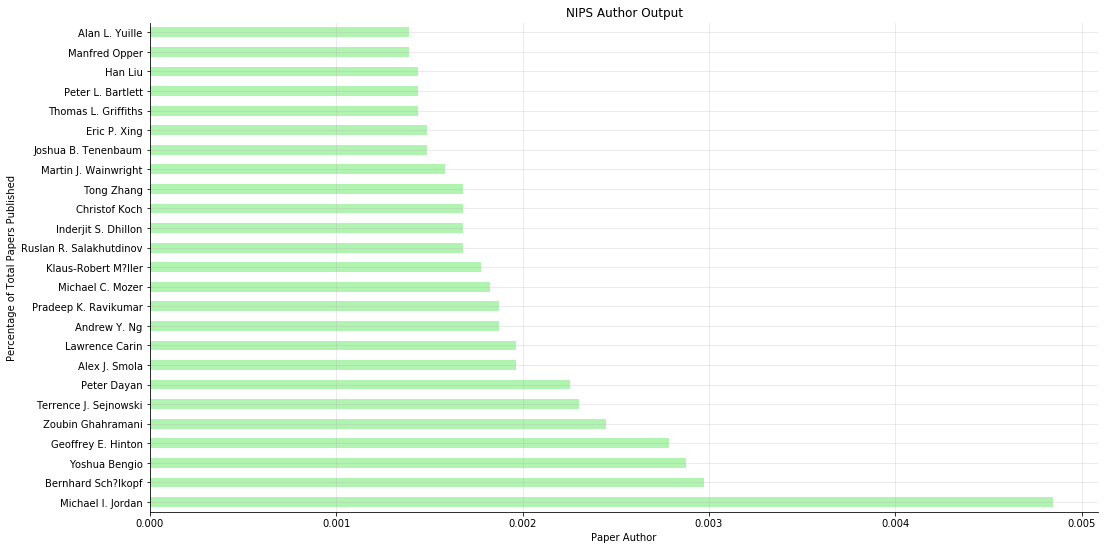

In [3]:
# note the matthew principle for author output
_ = df.groupby('author').title.count().sort_values(ascending=False).head(25) / df.groupby('author').title.count().sum()
fig, ax = plt.subplots(figsize=(17,9))
_.plot(ax=ax, kind='barh', alpha=.7, color='lightgreen')
ax.set_xlabel('Paper Author')
ax.set_ylabel('Percentage of Total Papers Published')
ax.set_title('NIPS Author Output')
sns.despine()
ax.grid(alpha=.3)
plt.show()

In [4]:
class TextCleaner(TransformerMixin):
    """Text cleaning to slot into sklearn interface"""

    def __init__(self, remove_stopwords=True, remove_urls=True,
                 remove_puncts=True, lemmatize=True, extra_punct='',
                 custom_stopwords=[], custom_non_stopwords=[],
                 verbose=True, parser='big'):
        """
        INPUT: remove_stopwords - bool - remove is, there, he etc...
               remove_urls - bool - 't www.monkey.com t' --> 't com t'
               remove_punct - bool - all punct and digits gone
               lemmatize - bool - whether to apply lemmtization
               extra_punct - str - other characters to remove
               custom_stopwords - list - add to standard stops
               custom_non_stopwords - list - make sure are kept
               verbose - bool - whether to print progress statements
               parser - str - 'big' or small, one keeps more, and is slower
        OUTPUT: self - **due to other method, not this one
        """
        # Initialize passed Attributes to specify operations
        self.remove_stopwords = remove_stopwords
        self.remove_urls = remove_urls
        self.remove_puncts = remove_puncts
        self.lemmatize = lemmatize

        # Change how operations work
        self.custom_stopwords = custom_stopwords
        self.custom_non_stopwords = custom_non_stopwords
        self.verbose = verbose

        # Set up punctation tranlation table
        self.removals = string.punctuation + string.digits + extra_punct
        self.trans_table = str.maketrans({key: None for key in self.removals})

        #Load nlp model for parsing usage later
        self.parser = spacy.load('en_core_web_sm', 
                                 disable=['parser','ner','textcat'])
        #from spacy.lang.en import English
        if parser == 'small':
            self.parser = spacy.load('en')#English()

        #Add custom stop words to nlp
        for word in self.custom_stopwords:
            self.parser.vocab[word].is_stop = True

        #Set custom nlp words to be kept
        for word in self.custom_non_stopwords:
            self.parser.vocab[word].is_stop = False


    def transform(self, X, y=None):
        """take array of docs to clean array of docs"""
        # Potential replace urls with tld ie www.monkey.com to com
        if self.remove_urls:
            start_time = time()
            if self.verbose:
                print("CHANGING URLS to TLDS...  ", end='')
            X = [self.remove_url(doc) for doc in X]
            if self.verbose:
                print(f"{time() - start_time:.0f} seconds")

        # Potentially remove punctuation
        if self.remove_puncts:
            start_time = time()
            if self.verbose:
                print("REMOVING PUNCTUATION AND DIGITS... ", end='')
            X = [doc.lower().translate(self.trans_table) for doc in X]
            if self.verbose:
                print(f"{time() - start_time:.0f} seconds")

        # Using Spacy to parse text
        start_time = time()
        if self.verbose:
            print("PARSING TEXT WITH SPACY... ", end='')
            
        X = list(self.parser.pipe(X))
        if self.verbose:
            print(f"{time() - start_time:.0f} seconds")

        # Potential stopword removal
        if self.remove_stopwords:
            start_time = time()
            if self.verbose:
                print("REMOVING STOP WORDS FROM DOCUMENTS... ", end='')
            X = [[word for word in doc if not word.is_stop] for doc in X]
            if self.verbose:
                print(f"{time() - start_time:.0f} seconds")


        # Potential Lemmatization
        if self.lemmatize:
            start_time = time()
            if self.verbose:
                print("LEMMATIZING WORDS... ", end='')
            X = [[word.lemma_ for word in doc] for doc in X]
            if self.verbose:
                print(f"{time() - start_time:.0f} seconds")

        # Put back to normal if no lemmatizing happened
        if not self.lemmatize:
            X = [[str(word).lower() for word in doc] for doc in X]

        # Join Back up
        return [' '.join(lst) for lst in X]


    def fit(self, X, y=None):
        """interface conforming, and allows use of fit_transform"""
        return self


    @staticmethod
    def remove_url(text):
        """
        DESCR: given a url string find urls and replace with top level domain
               a bit lazy in that if there are multiple all are replaced by first
        INPUT: text - str - 'this is www.monky.com in text'
        OUTPIT: str - 'this is <com> in text'
        """
        # Define string to match urls
        url_re = '((?:www|https?)(://)?[^\s]+)'

        # Find potential things to replace
        matches = re.findall(url_re, text)
        if matches == []:
            return text

        # Get tld of first match
        match = matches[0][0]
        try:
            tld = get_tld(match, fail_silently=True, fix_protocol=True)
        except ValueError:
            tld = None

        # failures return none so change to empty
        if tld is None:
            tld = ""

        # make this obvsiouyly an odd tag
        tld = f"<{tld}>"

        # Make replacements and return
        return re.sub(url_re, tld, text)

# Clean Text

## Clean Titles of Papers

In [5]:
custom_stopwords = ['et', 'al', 
                   'data', 'model', 'predict', 'learning', 'machine', 'datum']
cleaner = TextCleaner(custom_stopwords=custom_stopwords)

# transform with 
df['cleaned_title'] = cleaner.transform(df.title)

CHANGING URLS to TLDS...  0 seconds
REMOVING PUNCTUATION AND DIGITS... 0 seconds
PARSING TEXT WITH SPACY... 7 seconds
REMOVING STOP WORDS FROM DOCUMENTS... 0 seconds
LEMMATIZING WORDS... 0 seconds


In [6]:
df[['title', 'cleaned_title']].head(20)

,title,cleaned_title
0,Connectivity Versus Entropy,connectivity versus entropy
1,Stochastic Learning Networks and their Electro...,stochastic network electronic implementation
2,Stochastic Learning Networks and their Electro...,stochastic network electronic implementation
3,Stochastic Learning Networks and their Electro...,stochastic network electronic implementation
4,Stochastic Learning Networks and their Electro...,stochastic network electronic implementation
5,Learning on a General Network,general network
6,An Artificial Neural Network for Spatio-Tempor...,artificial neural network spatiotemporal bipol...
7,An Artificial Neural Network for Spatio-Tempor...,artificial neural network spatiotemporal bipol...
8,An Artificial Neural Network for Spatio-Tempor...,artificial neural network spatiotemporal bipol...
9,On Properties of Networks of Neuron-Like Elements,property network neuronlike element


## Clean Text of Papers

Text(0,0.5,'Count')

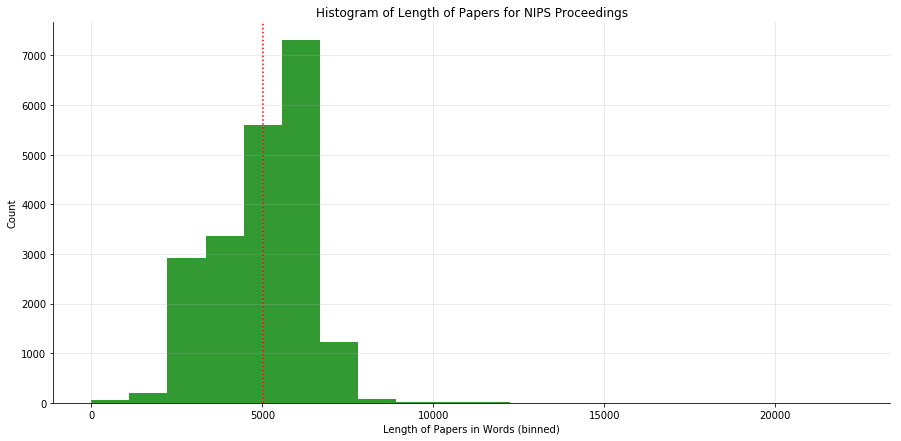

In [7]:
df['length_paper'] = df.paper_text.str.split().apply(len)

fig, ax = plt.subplots(figsize=(15,7))
ax.hist(df['length_paper'], label='length of paper (words)', color='green', alpha=.8, bins=20)
ax.axvline(df['length_paper'].mean(), label='mean', linestyle=':', color='red')
ax.grid(alpha=.3)
ax.set_title('Histogram of Length of Papers for NIPS Proceedings')
sns.despine()
ax.set_xlabel('Length of Papers in Words (binned)')
ax.set_ylabel('Count')

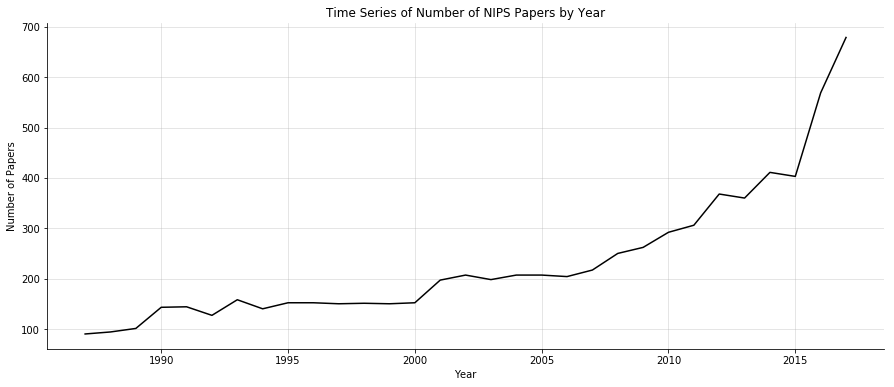

In [9]:
fig, ax = plt.subplots(figsize=(15, 6))
df.groupby('year')['title'].nunique().plot(ax=ax, color='black')
ax.grid(alpha=.4)
ax.set_title('Time Series of Number of NIPS Papers by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Papers')
sns.despine()

### Use first 2000 words in each paper to build models (for memory-related issues)

In [10]:
first_n = 2000

for i, text in enumerate(df.paper_text):
    df.loc[i, 'cleaned_text'] = ' '.join(text.split()[:first_n])
    
df['cleaned_text'] = cleaner.transform(df['cleaned_text'])

df[['paper_text', 'cleaned_text']].head(20)

CHANGING URLS to TLDS...  4 seconds
REMOVING PUNCTUATION AND DIGITS... 1 seconds
PARSING TEXT WITH SPACY... 1486 seconds
REMOVING STOP WORDS FROM DOCUMENTS... 25 seconds
LEMMATIZING WORDS... 25 seconds


,paper_text,cleaned_text
0,1\n\nCONNECTIVITY VERSUS ENTROPY\nYaser S. Abu...,connectivity versus entropy yaser s abumosta...
1,9\n\nStochastic Learning Networks and their El...,stochastic network electronic implementation...
2,9\n\nStochastic Learning Networks and their El...,stochastic network electronic implementation...
3,9\n\nStochastic Learning Networks and their El...,stochastic network electronic implementation...
4,9\n\nStochastic Learning Networks and their El...,stochastic network electronic implementation...
5,22\n\nLEARNING ON A GENERAL NETWORK\n\nAmir F....,general network amir f atiya department elec...
6,31\n\nAN ARTIFICIAL NEURAL NETWORK FOR SPATIOT...,artificial neural network spatiotemporal bip...
7,31\n\nAN ARTIFICIAL NEURAL NETWORK FOR SPATIOT...,artificial neural network spatiotemporal bip...
8,31\n\nAN ARTIFICIAL NEURAL NETWORK FOR SPATIOT...,artificial neural network spatiotemporal bip...
9,41\n\nON PROPERTIES OF NETWORKS\nOF NEURON-LIK...,property network neuronlike element pierre b...


### Write to disk & re-read if necessary

In [11]:
# df.to_csv('data/cleaned_data.csv', index=True)

In [12]:
# df = pd.read_csv('data/cleaned_data.csv')
# del df['Unnamed: 0']
# df.head()

### Combine Text & Title, Weighting Title More Heavily

In [13]:
# df['combined_cleaned_text'] = 
df['training_text'] = (df.cleaned_title.astype(str) + ' ')*2 + df.cleaned_text
df.loc[5, 'training_text'][:200]

'general network general network   general network amir f atiya department electrical engineering california institute technology   abstract paper generalize backpropagation method general network cont'

# Test `LatentDirichletAllocation` with `CountVectorizer`

In [14]:
def print_top_words(model, feature_names, n_top_words):
    '''from sklearn example website for LDA'''
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += "|".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

def count_vectorizer_lda(data_samples, n_features, n_components, n_top_words):
    '''adapted from sklearn example website for LDA'''
    # Use tf (raw term count) features for LDA.
    print("Extracting tf features for LDA...")
    tf_vectorizer = CountVectorizer(max_df=0.95, 
                                    min_df=.05,
                                    max_features=n_features,
                                    stop_words='english',
                                    ngram_range=(1, 3))
    t0 = time()
    tf = tf_vectorizer.fit_transform(data_samples)
    print("done in %0.3fs." % (time() - t0))
    print()

    print("Fitting LDA models with tf features")
    lda = LatentDirichletAllocation(n_components=n_components,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=77,
                                    n_jobs=-1,
                                    max_iter=25)
    t0 = time()
    lda.fit(tf)
    print("done in %0.3fs." % (time() - t0))

    print("\nTopics in LDA model:")
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, n_top_words)
    
    return lda, tf_feature_names
    

n_features = 1000
n_components = 10
n_top_words = 10

lda, feature_names = count_vectorizer_lda(df['training_text'], 
                                          n_features, n_components, n_top_words)

Extracting tf features for LDA...
done in 89.347s.

Fitting LDA models with tf features
done in 608.392s.

Topics in LDA model:
Topic #0: neuron|spike|response|cell|stimulus|activity|neural|pattern|input|brain
Topic #1: set|label|loss|algorithm|training|class|example|classification|function|classifier
Topic #2: algorithm|gradient|method|xt|function|stochastic|update|convergence|optimization|parameter
Topic #3: task|time|signal|model|source|human|target|filter|sequence|motion
Topic #4: image|feature|object|cluster|graph|set|representation|point|approach|method
Topic #5: state|policy|action|algorithm|function|problem|reward|value|set|agent
Topic #6: matrix|problem|function|algorithm|kernel|method|vector|set|linear|result
Topic #7: distribution|model|variable|inference|sample|parameter|gaussian|probability|prior|latent
Topic #8: time|input|memory|weight|figure|output|rule|circuit|number|event
Topic #9: network|neural|layer|input|neural network|output|training|train|deep|unit



# Test `LatentDirichletAllocation` with `TfidfVectorizer`

In [16]:
def tfidf_vectorizer_lda(data_samples, n_features, n_components, n_top_words):
    '''adapted from sklearn example website for LDA'''
    # Use tf-idf features for LDA.
    print("Extracting tf-idf features for LDA...")
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
                                       min_df=.05,
                                       max_features=n_features,
                                       stop_words='english',
                                       ngram_range=(1, 3))
    t0 = time()
    tf = tfidf_vectorizer.fit_transform(data_samples)
    print("done in %0.3fs." % (time() - t0))
    print()

    print("Fitting LDA models with tf-idf features")
    lda = LatentDirichletAllocation(n_components=n_components,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=77,
                                    n_jobs=-1,
                                    max_iter=25)
    t0 = time()
    lda.fit(tf)
    print("done in %0.3fs." % (time() - t0))

    print("\nTopics in LDA model:")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    print_top_words(lda, tfidf_feature_names, n_top_words)
    
    return lda, tfidf_feature_names
    

n_features = 1000
n_components = 10
n_top_words = 10

tfidf_lda, tfidf_feature_names = tfidf_vectorizer_lda(df['training_text'], 
                                                      n_features, n_components, n_top_words)

Extracting tf-idf features for LDA...
done in 92.464s.

Fitting LDA models with tf-idf features
done in 306.209s.

Topics in LDA model:
Topic #0: network|image|neuron|neural|input|layer|object|spike|feature|neural network
Topic #1: lemma|patch|spike|transformation|nonzero|column|sequential|pose|entire|feedforward
Topic #2: algorithm|policy|problem|function|reward|action|matrix|gradient|state|method
Topic #3: lemma|patch|spike|transformation|nonzero|column|sequential|pose|entire|feedforward
Topic #4: classifier|label|loss|risk|classification|margin|error|training|hypothesis|class
Topic #5: lemma|patch|spike|transformation|nonzero|column|sequential|pose|entire|feedforward
Topic #6: lemma|patch|spike|transformation|nonzero|column|sequential|pose|entire|feedforward
Topic #7: circuit|analog|lemma|implementation|technology|current|implement|operation|rl|differential
Topic #8: lemma|patch|spike|transformation|nonzero|column|sequential|pose|entire|feedforward
Topic #9: distribution|graph|kerne

# Test `apriori` with `TransactionEncoder`

In [18]:
oht = TransactionEncoder()
ls = df.cleaned_title.str.split().tolist()
#oht.fit(ls)
oht_ary = oht.fit_transform(ls)
oht_df = pd.DataFrame(oht_ary, columns=oht.columns_)
oht_df.head()

,-PRON-,abandon,ability,absence,absolute,absorb,abstention,abstract,abstraction,accelerate,...,zerocrossing,zeroone,zeroorder,zeroshot,zerosum,zerothorder,zeta,zforc,zigzag,zip
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [19]:
# check itemsets that appear in at least min_support% of baskets
freq_itemsets = apriori(oht_df, min_support=.005, use_colnames=True)
freq_itemsets['length'] = freq_itemsets['itemsets'].apply(lambda x: len(x))
freq_itemsets.sort_values('support', ascending=False).head(10)

,support,itemsets,length
131,0.115541,(network),1
132,0.088623,(neural),1
122,0.077396,(model),1
237,0.056523,"(neural, network)",2
6,0.043088,(algorithm),1
15,0.038962,(bayesian),1
92,0.036706,(inference),1
157,0.034643,(process),1
45,0.034355,(deep),1
97,0.033396,(kernel),1


In [20]:
freq_itemsets.loc[(freq_itemsets['length'] >= 2) & (freq_itemsets['support'] >= .005)].sort_values('support', ascending=False)

,support,itemsets,length
237,0.056523,"(neural, network)",2
231,0.016746,"(process, gaussian)",2
226,0.011708,"(network, deep)",2
238,0.011516,"(recurrent, network)",2
233,0.009309,"(model, graphical)",2
234,0.008541,"(model, inference)",2
225,0.007965,"(network, convolutional)",2
242,0.007917,"(support, vector)",2
235,0.007581,"(variational, inference)",2
239,0.007437,"(recurrent, neural)",2


In [21]:
association_rules(
    freq_itemsets, metric="confidence", min_threshold=0.2
).sort_values('consequent support', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
16,(neural),(network),0.088623,0.115541,0.056523,0.637791,5.520018,0.046284,2.441846
3,(convolutional),(network),0.009980,0.115541,0.007965,0.798077,6.907276,0.006812,4.380176
4,(deep),(network),0.034355,0.115541,0.011708,0.340782,2.949435,0.007738,1.341679
28,"(recurrent, neural)",(network),0.007437,0.115541,0.006813,0.916129,7.929005,0.005954,10.545467
7,(dynamic),(network),0.026726,0.115541,0.005662,0.211849,1.833534,0.002574,1.122195
26,"(neural, deep)",(network),0.006670,0.115541,0.005806,0.870504,7.534122,0.005035,6.829985
18,(recurrent),(network),0.016122,0.115541,0.011516,0.714286,6.182072,0.009653,3.095605
29,"(recurrent, network)",(neural),0.011516,0.088623,0.006813,0.591667,6.676191,0.005793,2.231943
27,"(network, deep)",(neural),0.011708,0.088623,0.005806,0.495902,5.595607,0.004768,1.807934
19,(recurrent),(neural),0.016122,0.088623,0.007437,0.461310,5.205280,0.006008,1.691837


# Test `gensim.Word2Vec`

/Users/pmw/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  from ipykernel import kernelapp as app


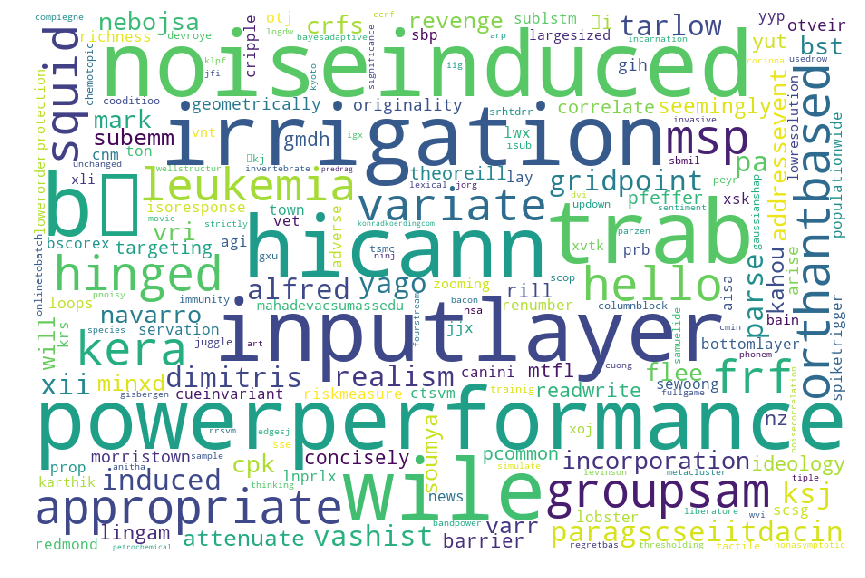

img/image_850.jpeg


'img/image_850.jpeg'

<Figure size 432x288 with 0 Axes>

In [22]:
# gather sentences split by words
sentences = []
for txt in df.training_text.astype(str).tolist():
    sentences.append(txt.split())

# train model 
model = Word2Vec(iter=10, min_count=10, size=150, workers=-1)
model.build_vocab(sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

topn = 200
test_words = ['neural']
dat = model.most_similar(test_words, topn=topn)
_df = pd.DataFrame(dat, columns=['word', 'prob']).set_index('word')

import wordcloud
from wordcloud import WordCloud
import os
import glob

def generate_wordcloud(words, values, savefig=1):
    '''
    Inputs:
    -----------------------------------------------------------------
     words: np.array of words to be plotted
     values: np.array of corresponding weights/sizes of text
     
    Outputs:
    -----------------------------------------------------------------
     None: prints matplotlib
    '''
    word_dict = dict(zip(words, values))

    cloud = WordCloud(background_color='white',
                      max_words=200,
                      max_font_size=100,
                      random_state=42,
                      width=900,
                      height=600).generate_from_frequencies(frequencies=word_dict)

    fig = plt.figure(1, figsize=(20, 10))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

    # remove old images
    for filename in glob.glob('img/image_*'):
        os.remove(filename)

    # save image without white borders
    img_path = 'img/image_'+str(np.random.randint(100, 999))+'.jpeg'; print(img_path)
    plt.savefig(img_path, bbox_inches='tight')

    return img_path

words = _df.index.values
values = _df.prob
generate_wordcloud(words, values, savefig=1)

# Final Approach - Steps to Develop

## Group data by year & Perform `TransactionEncoder` `apriori` Frequent Itemsets 

The resulting support scores from iteratively applying `apriori` to each year's papers are cached to a `DataFrame` that is indexed by year and itemset.  This enables subsequent analysis of the support that a given "topic" received during a period.  Identification of growing itemsets is also enabled since temporal resolution is achieved using this method.  To scale the measurements by the growth of the conference each support score was multiplied by 100 (to discourage underflow), then the sum total number of (unique) papers for the entire year is multiplied by each adjusted support score.  This methodology was not necessarily mathematically inspired, nor theoretically driven.  It was merely a convenient heuristic for adjusting the data, and it likely has many flaws.  

    
### Observe which topics have the highest average support (but are not necessarily growing)

In [24]:
def transaction_encoder_apriori_frequent_itemsets(ls, min_support=.005):
    # instantiate TransactionEncoder
    oht = TransactionEncoder()
    oht_ary = oht.fit_transform(ls)
    oht_df = pd.DataFrame(oht_ary, columns=oht.columns_)
    
    # check itemsets that appear in at least min_support% of baskets
    freq_itemsets = apriori(oht_df, min_support=min_support, use_colnames=True)
    freq_itemsets['length'] = freq_itemsets['itemsets'].apply(lambda x: len(x))
    
    return freq_itemsets.sort_values('support', ascending=False)

fis_df = pd.DataFrame()

for year, _df in df.groupby('year'):
    text_lists = _df.cleaned_title.str.split().tolist()
    frequent_itemsets = transaction_encoder_apriori_frequent_itemsets(text_lists)
    frequent_itemsets['year'] = year
    frequent_itemsets.set_index(['year', 'itemsets'], inplace=True)
    # derive number of papers for that year
    n_papers = _df['cleaned_title'].nunique()
    frequent_itemsets['n_unique_papers'] = n_papers
    fis_df = fis_df.append(frequent_itemsets)
    
# bring row index to columns
fis_df = fis_df.unstack('year')

# fill na and sort dataframe by support
fis_df = fis_df.fillna(0)
fis_df['mean_support'] = fis_df['support'].mean(axis=1)

# sort by the average support of each topic
fis_df.sort_values('mean_support', ascending=False, inplace=True)

# display top 10 itemsets
top_n = 10
print('Top %i Itemsets' %top_n)
fis_df[['mean_support']].head(top_n); print('')

# isolate just the support dataframe by its MultiIndex
# the data is already sorted
fis_support_df = fis_df['support'].T

fis_support_df.head()

Top 10 Itemsets



itemsets,(network),(neural),"(neural, network)",(model),(algorithm),(bayesian),(recognition),(classification),(analysis),(kernel),...,"(informationtheoretic, optimization, bound)","(classification, hierarchical, uncover)","(informationtheoretic, oracle, bound)","(low, optimization, bound)","(random, conditional, sequence)","(unsupervised, convolutional, belief)","(random, semisupervised, conditional)","(labeling, conditional, sequence)","(region, classification, hierarchical)","(model, coreference)"
year,,,,,,,,,,,,,,,,,,,,,
1987,0.519774,0.446328,0.344633,0.039548,0.016949,0.000000,0.016949,0.056497,0.028249,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,0.417040,0.412556,0.255605,0.062780,0.026906,0.000000,0.017937,0.026906,0.013453,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989,0.438596,0.302632,0.236842,0.021930,0.083333,0.008772,0.083333,0.030702,0.021930,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990,0.412308,0.320000,0.280000,0.021538,0.027692,0.000000,0.120000,0.033846,0.012308,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991,0.350000,0.241176,0.179412,0.058824,0.011765,0.014706,0.152941,0.017647,0.020588,0.005882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# fis_df['support_*_npapers'] = np.multiply(fis_df['support'], fis_df['n_unique_papers']) 

### Observe number of NIPS papers per year

Text(0.5,1,'Number of NIPS Papers per Year')

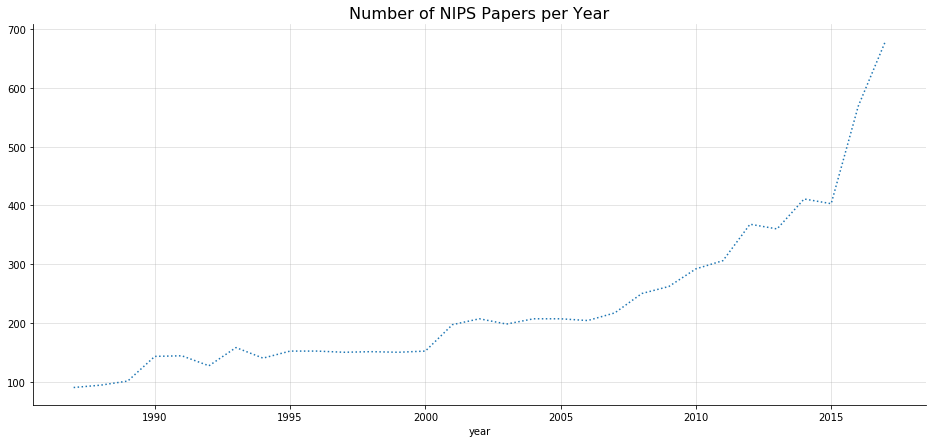

In [26]:
# show number of papers per year -- note growing conference
fig, ax = plt.subplots(figsize=(16, 7))
fis_df['n_unique_papers'].max(axis=0).T.plot(ax=ax, linestyle=':')
ax.grid(alpha=.4)
sns.despine()
ax.set_title('Number of NIPS Papers per Year', size=16)

### Adjust for size of conference

Below each itemset's support score is first multiplied by 100, then it is multiplied by the number of papers for that year.  This is done as a simple way of adjusting for the size of the conference.  There are undoubtedly better heuristics and methods for doing this.

In [27]:
# id actual n_unique_papers by year (max used for zeros)
n_papers_by_year = fis_df['n_unique_papers'].max(axis=0).T # max used bc 0 shows up in matrix form, bug?

# iterate over columns in un-adjusted df to get adjusted df
# by first multiplying the score by 100 then muliplying it again by the n_papers_by_year
fis_adj_df = pd.DataFrame()
for col in fis_support_df.columns.tolist()[:500]:
    fis_adj_df[col] = np.multiply(fis_support_df[col], 100) 
    fis_adj_df[col] = np.multiply(fis_adj_df[col], n_papers_by_year)
    
fis_adj_df.head()

,(network),(neural),"(neural, network)",(model),(algorithm),(bayesian),(recognition),(classification),(analysis),(kernel),...,"(neural, approach, network)",(storage),"(code, neural)",(principle),(ica),"(model, recognition)",(expression),"(network, multilayer)",(neighbor),"(multilayer, perceptron)"
year,,,,,,,,,,,,,,,,,,,,,
1987,4677.966102,4016.949153,3101.694915,355.932203,152.542373,0.000000,152.542373,508.474576,254.237288,0.000000,...,203.389831,305.084746,0.000000,101.694915,0.0,0.000000,0.0,0.000000,0.0,0.000000
1988,3920.179372,3878.026906,2402.690583,590.134529,252.914798,0.000000,168.609865,252.914798,126.457399,0.000000,...,84.304933,126.457399,379.372197,84.304933,0.0,0.000000,0.0,252.914798,0.0,252.914798
1989,4429.824561,3056.578947,2392.105263,221.491228,841.666667,88.596491,841.666667,310.087719,221.491228,0.000000,...,0.000000,88.596491,177.192982,88.596491,0.0,0.000000,0.0,0.000000,0.0,0.000000
1990,5896.000000,4576.000000,4004.000000,308.000000,396.000000,0.000000,1716.000000,484.000000,176.000000,0.000000,...,352.000000,132.000000,0.000000,132.000000,0.0,132.000000,0.0,0.000000,0.0,440.000000
1991,5040.000000,3472.941176,2583.529412,847.058824,169.411765,211.764706,2202.352941,254.117647,296.470588,84.705882,...,0.000000,0.000000,0.000000,0.000000,0.0,127.058824,0.0,84.705882,0.0,0.000000


### Review preliminary results

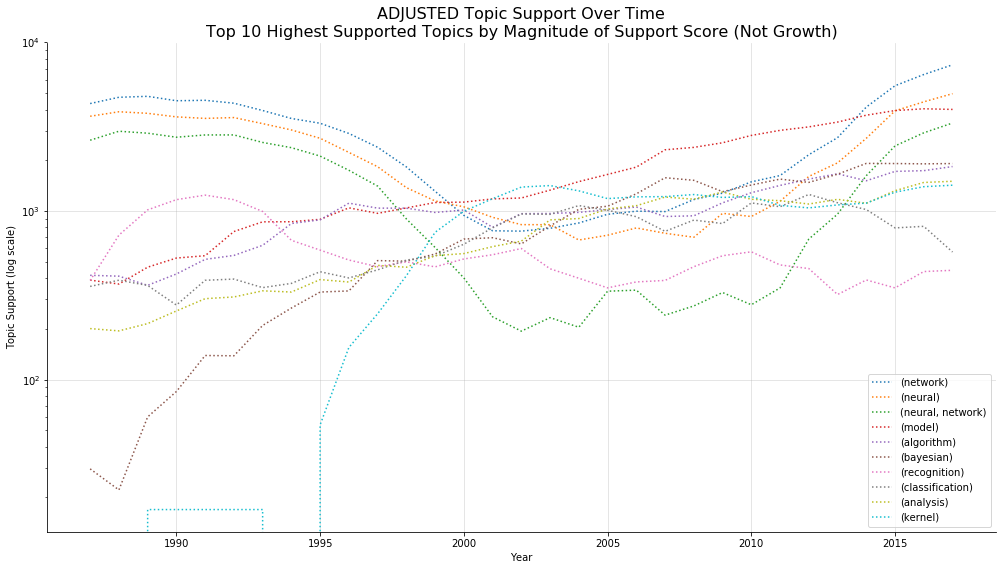

In [28]:
# plot what it looks like topic-wise
fig, ax = plt.subplots(figsize=(17,9))
top_10_topics = fis_adj_df.columns.tolist()[:10]
fis_adj_df[top_10_topics].rolling(5, min_periods=3, center=True).mean().plot(ax=ax, linestyle=':')
ax.grid(alpha=.4)
sns.despine()
ax.set_title('ADJUSTED Topic Support Over Time\nTop 10 Highest Supported Topics by Magnitude of Support Score (Not Growth)', 
             size=16)
ax.semilogy()
ax.set_ylabel('Topic Support (log scale)')
ax.set_xlabel('Year')
ax.legend(loc='best')
plt.show()

# Identification of growing frequent itemsets

Using the `pd.DataFrame.diff()` method to derive time-series differences, then summing those differences, it is possible to determine which topics overall had positive support.  An arbitrary cutoff of 0.01 was used, then frequent itemsets longer than two words are selected in order to identify phrase-like itemsets that may be indicative of the next hot topic in ML.  

Plotted below is a cumulative sum of the sequential temporal differences in support for all itemsets of length greater than or equal to two words.  The concepts of deep learning & neural networks are certainly of interest to the community, as evidenced by the many terms related to deep learning itemsets dominating the in the top 10.  In future iterations on this problem an investigator could remove some stop-words that are all-too-common in the results thus far and see if it sifts through the noise better.  A potential issue in removing such stop-words could arise from the fact that some of these words are *bridge* words (such as "neural") that tie together multiple others in a meaningful way.  

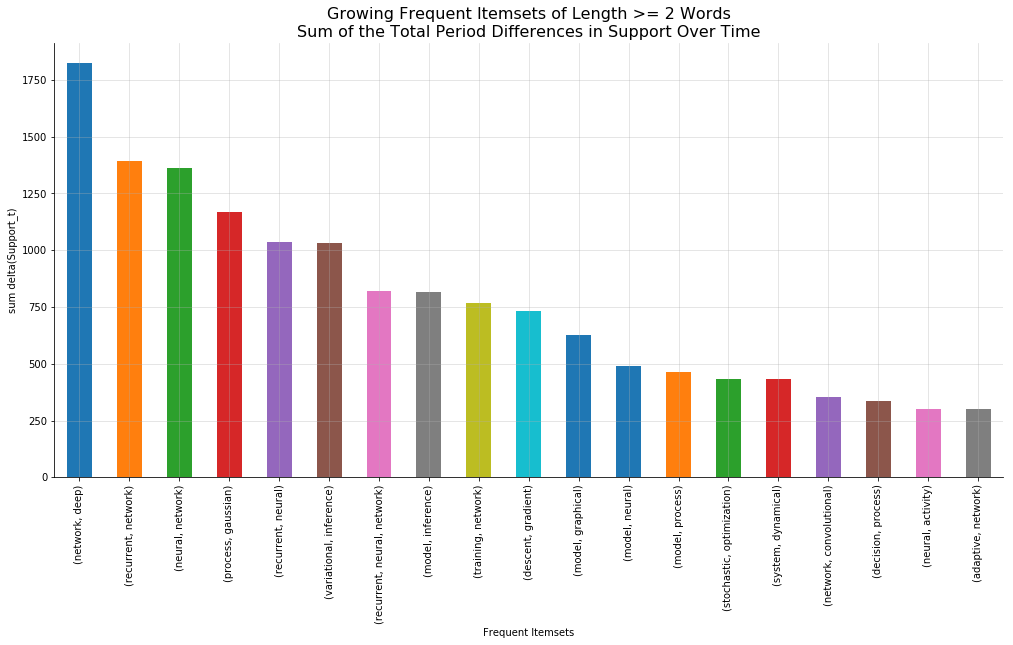

In [29]:
# id filters for growing itemsets and 2+ words itemsets
growing_itemsets = fis_adj_df.diff().sum() > 0.01
length_gte2 = fis_adj_df.columns.str.len() >= 2

# show itemsets growing more than .01 and topics >= 2 words
fig, ax = plt.subplots(figsize=(17,8))
fis_adj_df.diff().sum()[growing_itemsets & length_gte2].sort_values(ascending=False).plot(ax=ax, kind='bar')
sns.despine()
ax.grid(alpha=.4)
ax.set_xlabel('Frequent Itemsets')
ax.set_ylabel('sum delta(Support_t)')
ax.set_title('Growing Frequent Itemsets of Length >= 2 Words\nSum of the Total Period Differences in Support Over Time',
            size=16)
plt.show()

## Look at growing itemsets regardless of length

As mentioned above, the top growing itemsets (regardless of the number of words that comprise it) contain such bridge words as "model", "algorithm", and "function".  These words on their own are not particularly meaningful.  Shown below are the top 10 itemsets, then their time-series of support is plotted.

In [30]:
growing_cols = [col for (col,b) in growing_itemsets.items() if b==True]
growing_cols[:10]

[frozenset({'network'}),
 frozenset({'neural'}),
 frozenset({'network', 'neural'}),
 frozenset({'model'}),
 frozenset({'algorithm'}),
 frozenset({'bayesian'}),
 frozenset({'recognition'}),
 frozenset({'classification'}),
 frozenset({'analysis'}),
 frozenset({'kernel'})]

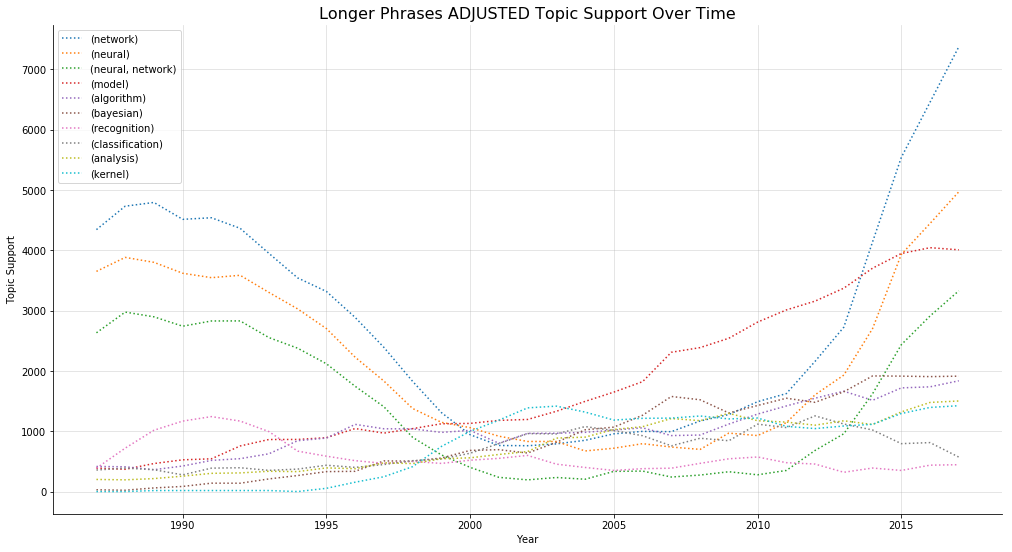

In [31]:
# plot what it looks like topic-wise
fig, ax = plt.subplots(figsize=(17,9))
fis_adj_df[growing_cols[:10]].rolling(5, min_periods=3, center=True).mean().plot(ax=ax, linestyle=':')
ax.grid(alpha=.4)
sns.despine()
ax.set_title('Longer Phrases ADJUSTED Topic Support Over Time', size=16)
ax.set_ylabel('Topic Support')
ax.set_xlabel('Year')
ax.legend(loc='best')
#ax.semilogy()
plt.show()

# Final Approach - Results

## Review the long and growing itemsets

Below all itemsets that are (1) greater than or equal to 2 words in length and (2) are growing are isolated, then plotted against time.  It is observed that the concept of "neural networks" is dominating the signal here, and in future iterations steps should be taken to remove such dominance.  

As an aside, both `MinMaxScaler` and `StandardScaler` were tested and subsequently plotted, but the distortions that are created served more to confuse than to enlighten.  For this reason the approach was not used.

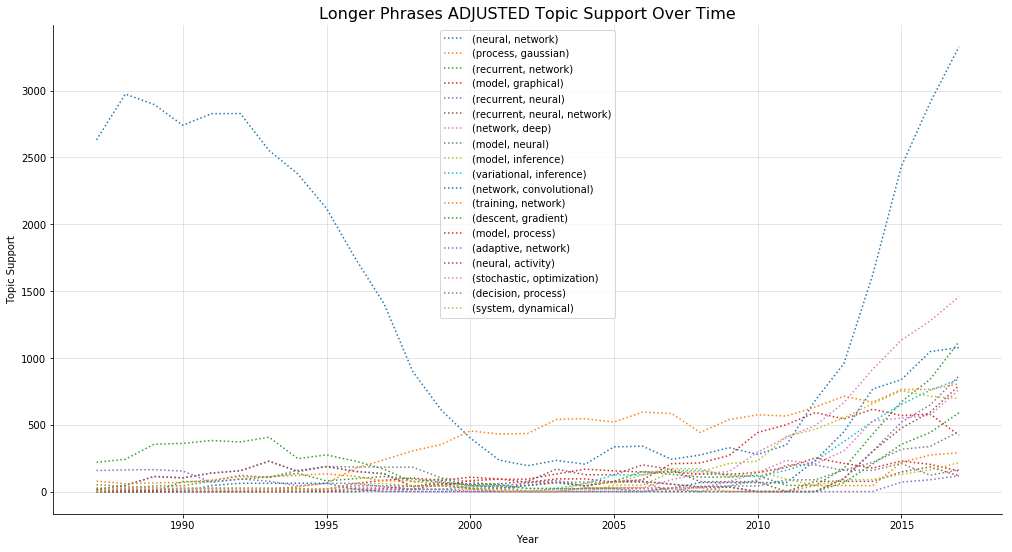

In [32]:
# filter for length of items in itemset
growing_and_gte2 = [col for col in growing_cols if len(str(col).split(',')) >= 2]

# use rolling 5 period mean for all growing vectors gte len 2
long_and_growing = fis_adj_df[growing_and_gte2].rolling(5, min_periods=3, center=True).mean()

# # normalize
# from sklearn.preprocessing import MinMaxScaler
# long_and_growing = pd.DataFrame(MinMaxScaler().fit_transform(long_and_growing), 
#                                 index=long_and_growing.index,
#                                 columns=long_and_growing.columns)

# plot what it looks like topic-wise
fig, ax = plt.subplots(figsize=(17,9))
long_and_growing.plot(ax=ax, linestyle=':')
ax.grid(alpha=.4)
sns.despine()
ax.set_title('Longer Phrases ADJUSTED Topic Support Over Time', size=16)
ax.set_ylabel('Topic Support')
ax.set_xlabel('Year')
ax.legend(loc='best')
plt.show()

In [33]:
## Stillborn ideas -- ideas time didn't allow to come to fruition

# test earth mover distance
# check out ToPMINE -- no python library
# account for perplexity and coherence scores - interpret them 
# choose N topics using them with apriori distributions
# Loop through by year and perform gensim wordcloud aganist each term